# カルマンフィルタについての実験的コード
[こちら](https://www.kalmanfilter.net/JP/alphabeta_jp.html)の記事を参考にしている．

記号などは参考の記事に若干の変更を加えている．

（注）notebookの数式環境のeqrefがバグってるかも。。。

->（20240609）eqref参照せず，ベタ打ちした

## カルマンフィルタとは
1. 観測データからシステムの状態を推定（補正）する方法

## $\alpha - \beta$フィルタ
### 問題設定１ 静的システム
静的システムを推定する．（質量を時間変化しないものとする＝静的システム，質量のようなもの）

- $x$: 状態量
- $\hat{x}_n$: n回目の推定値
- $z_n$: n回目の測定で得られた観測値

$\hat{x}_n$を

$$
\hat{x}_n = \frac{1}{n}\sum_{i=1}^{n}z_i \tag{1}
$$
と定義する．なおこのとき，$\hat{x}_n$は観測値の平均と捉えることができる．

この元で，
$$
\begin{align}
    \hat{x}_n &= \frac{1}{n}\sum_{i=1}^{n}z_i  \\
    &= \frac{1}{n}\left( z_n + \sum_{i=1}^{n-1}z_i \right) \\
    &= \frac{1}{n}z_n + \frac{n-1}{n} \cdot \frac{1}{n-1} \sum_{i=1}^{n-1}z_i \tag{2} 
\end{align} 
$$
となる．
ここで，
$$
\hat{x}_{n-1} = \frac{1}{n-1}\sum_{i=1}^{n-1}z_i
$$
であるから，$(2)$式は
$$
\begin{align}
    \hat{x}_n &= \frac{1}{n}z_n + \frac{n-1}{n} \cdot \frac{1}{n-1} \sum_{i=1}^{n-1}z_i \\
    &= \frac{1}{n}z_n + \frac{n-1}{n} \hat{x}_{n-1} \\
    &= \hat{x}_{n-1} + \frac{1}{n} (z_n - \hat{x}_{n-1}) \tag{3}
\end{align} 
$$
と書ける．ここで，$(1)$式を用いると，全ての観測値$z_k,\,\, k=\{1 \cdots n\}$を保存しておく必要があったが，$(3)$式では，$n$回目の観測値と$n-1$回目の推定値があれば計算可能であることに注意する．

なお，$(3)$式の$\frac{1}{n}$は**カルマンゲイン**と呼ばれ，問題固有の値である．このカルマンゲインを$K_n$とすると，一般に$(3)$は，
$$
\begin{align}
    \hat{x}_n = \hat{x}_{n-1} + K_n (z_n - \hat{x}_{n-1}) \tag{4}
\end{align} 
$$
と書け，これを状態更新式という．この式は次のような意味である．
$$
補正された現在の状態の推定値　＝　前の状態→現在の状態の補正された予測値　+　補正値　×　(現在の状態の観測値　ー　前の状態→現在の状態の補正された予測値)
$$
なお，右辺第二項目の現在の状態の観測値　ー　前の状態→現在の状態の補正された予測値を**予測誤差（innovation）**と呼ぶ．

In [2]:
import numpy as np
import matplotlib.pyplot as plt
m = 100 # 真の質量
n = 20 # 測定回数
rng = np.random.default_rng(111)
noise = rng.normal(loc=0.0, scale=1.0, size=(n, 1)) # ノイズ
observe_f = np.hstack([np.ones(n).reshape(-1,1), noise]) # 状態から観測量を得る関数（＝ベクトル）
observables = observe_f @ np.array([[m],[1]])# 観測値 = 真の値＋ノイズ
# 状態更新式によってより近い推定値を求める
x_hat = 99.26
x_hats = np.array([x_hat])
for i in range(1, n):
    K_n = 1/i
    #K_n = 0.1
    x_hat = x_hat + K_n * (observables[i-1, :] - x_hat)
    x_hats = np.append(x_hats, x_hat)

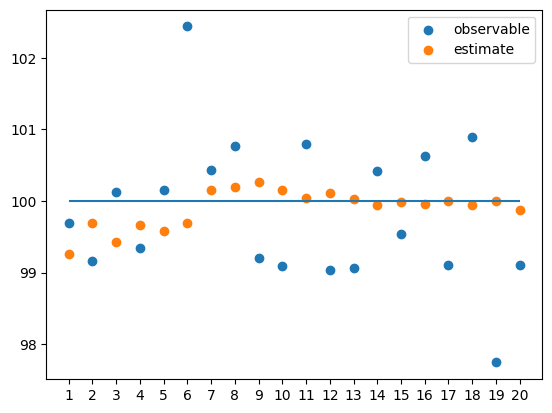

In [3]:
plt.hlines(xmin=1, xmax=n, y=m)
plt.scatter(np.arange(1, n+1), observables, label="observable")
plt.scatter(np.arange(1, n+1), x_hats, label="estimate")
plt.xticks(np.arange(1, n+1))
plt.legend()
plt.show()

### 問題設定２　動的システム（１次元系）
等速運動をする物体の位置を$x$として，それを推定する．（具体的には，飛んでる飛行機の位置座標を$x$として，レーダーを用いて観測する）

今，時刻$n$における物体の位置および速度をそれぞれ$\boldsymbol{x}_n,\, \boldsymbol{v}_n$とする．このとき，$\dot{\boldsymbol{x}}$を
$$
\dot{\boldsymbol{x}} = \boldsymbol{v} = \frac{d\boldsymbol{x}}{dt}
$$
とし，物体の位置を観測する時間間隔を$\Delta t$として$\boldsymbol{v}$を離散化すれば，
$$
\boldsymbol{v} = \frac{\Delta x}{\Delta t}
$$
である．また，位置に関して，
$$
\boldsymbol{x}_{n+1} = \boldsymbol{x}_n + \Delta t \dot{\boldsymbol{x}}_n \tag{5}
$$
である．さらに，等速運動であるので
$$
\dot{\boldsymbol{x}}_{n+1} = \dot{\boldsymbol{x}}_n
$$
である．これら２式を状態方程式と呼び，現在の状態から次の状態の予測値を与える方程式である．

さて次に，これらの状態方程式より，状態更新式を導出する．
状態更新式は，前項より
$$
\begin{align}
    \hat{x}_n = \hat{x}_{n-1} + K_n (z_n - \hat{x}_{n-1}) \tag{6}
\end{align} 
$$
で与えられることがわかった．よって，位置$x_n$と速度$v_n$のカルマンゲインをそれぞれ$\alpha$，$\beta$とおけば，
$$
\begin{align}
    \hat{x}_n = \hat{x}_{n-1} + \alpha (z_n - \hat{x}_{n-1}) \tag{7} \\
    \hat{\dot{x}}_n = \hat{\dot{x}}_{n-1} + \beta \left( \frac{z_n - \hat{x}_{n-1}}{\Delta t} \right) \tag{8}
\end{align} 
$$
と書くことができる．なお，
$$
\left( \frac{z_n - \hat{x}_{n-1}}{\Delta t} \right)
$$
の項は予測誤差を$\Delta t$で割ったものであり，速度における予測誤差を表している（と考えられる、、、検証が必要、、、現状そんな感じの理解）．

以下では，参考元の例ともに具体的に考えてみる．まず，初期位置を$30000 \mathrm{\,m}$，速度を$40\mathrm{\, m/s}$とする．

さらに，$\Delta t = 5\mathrm{\, s}$で測定を行ったところ，１度目の測定で$z_n=30110\mathrm{\, m/s}$

という結果が得られた．この結果より速度についての状態更新式は，
$$
\begin{align}
    \hat{\dot{x}}_n &= \hat{\dot{x}}_{n-1} + \beta \left( \frac{z_n - \hat{x}_{n-1}}{\Delta t} \right) \\
    &= 40 + \beta \left( \frac{30,110 - \left( 30,000 + 40 \times5 \right)}{5} \right) \tag{9}
\end{align} 
$$
と書ける．ここで問題になってくるのが$\beta$の値である．更新に際して$\beta$をどのように設定すればよいか．
このとき，次の２つのケースを設定し，それぞれについて具体的に考えてみる．

なお，今回考える２つのケースは

1. 本当に速度が変わった
2. 測定器の精度が良くない
   
である．
### ケース１
仮に測定器の精度を$1\sigma=20$とすれば，今回のように$90\mathrm{\, m}$の誤差が出ることは確率的に考えにくい．

この場合，速度が変わったと考えるのが妥当であろう（すなわち，モデルの予測値があまり良くなく，観測値を信頼する）．

よって，カルマンゲイン$\beta$を高く設定し速度についての補正を強く入れる（$\beta=0.9$のように
）．

よってこの場合の速度は$(9)$式によって
$$
\begin{align}
    \hat{\dot{x}}_n &= \hat{\dot{x}}_{n-1} + \beta \left( \frac{z_n - \hat{x}_{n-1}}{\Delta t} \right) \\
    &= 40 + 0.9 \left( \frac{30,110 - \left( 30,000 + 40 \times5 \right)}{5} \right) \tag{10} \\
    &= 23.8 \mathrm{\, m/s}
\end{align} 
$$
と更新される．

### ケース２
仮に測定器の精度を$1\sigma=150$とすれば，今回のように$90\mathrm{\, m}$の誤差が出ることはありうる．

この場合，測定器の誤差によってこのような誤差が生まれたと考えるのが妥当であろう（予測値はほどほど良い結果を与えていた，さらに測定誤差は測定回数を増やせば丸め込まれるので予測値に重きを置く）．

よって，カルマンゲイン$\beta$を高く設定し速度についての補正を弱く入れる（$\beta=0.1$のように
）．

よってこの場合の速度は$(9)$式によって
$$
\begin{align}
    \hat{\dot{x}}_n &= \hat{\dot{x}}_{n-1} + \beta \left( \frac{z_n - \hat{x}_{n-1}}{\Delta t} \right) \\
    &= 40 + 0.1 \left( \frac{30,110 - \left( 30,000 + 40 \times5 \right)}{5} \right) \tag{10} \\
    &= 38.2 \mathrm{\, m/s}
\end{align} 
$$
と更新される．


In [23]:
delta_t = 5
n = 100
v_n = 50
x_n = np.ones((n//delta_t+1, 1))
for i in range(0, n+1, 5):
    x_n[i//5] *= v_n * i + 3.0*10**4
rng2 = np.random.default_rng(113)
noise2 = rng2.normal(loc=0.0, scale=150.0, size=(n//delta_t+1, 1))
observe_f2 = np.hstack([np.ones(n//delta_t+1).reshape(-1,1), noise2])

z_n = np.diag(observe_f2 @ np.hstack((x_n, np.ones(n//delta_t+1).reshape(-1,1))).T)

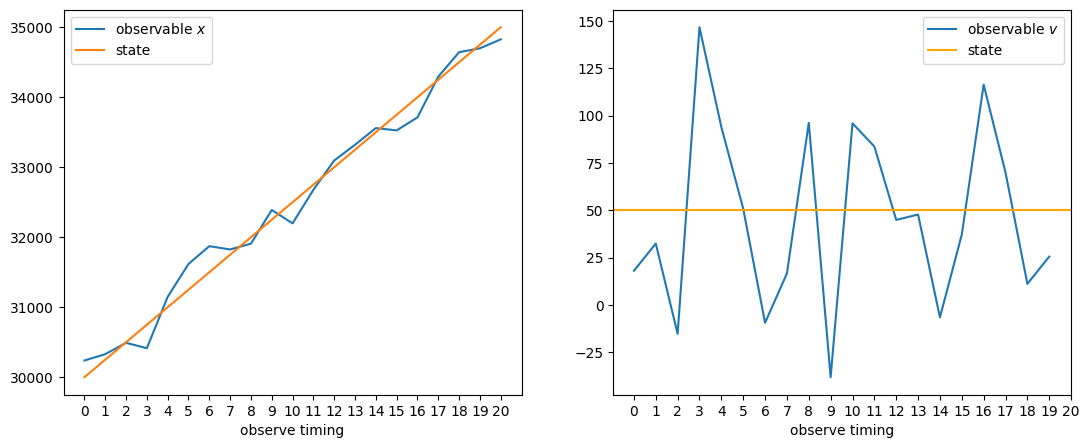

In [24]:
# 問題設定をグラフ化
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(np.arange(0, n//delta_t+1), z_n, label="observable $x$")
ax1.plot(np.arange(0, n//delta_t+1), x_n, label="state")
ax1.set_xlabel("observe timing")
ax1.set_xticks(np.arange(0, n//delta_t+1))

ax2.plot(np.arange(0, n//delta_t), (z_n[1:] - z_n[0:-1])/delta_t, label="observable $v$")
ax2.axhline(v_n, xmin=0, xmax=19, label="state", color="orange")
ax2.set_xlabel("observe timing")
ax2.set_xticks(np.arange(0, n//delta_t+1))

ax1.legend()
ax2.legend()
plt.show()

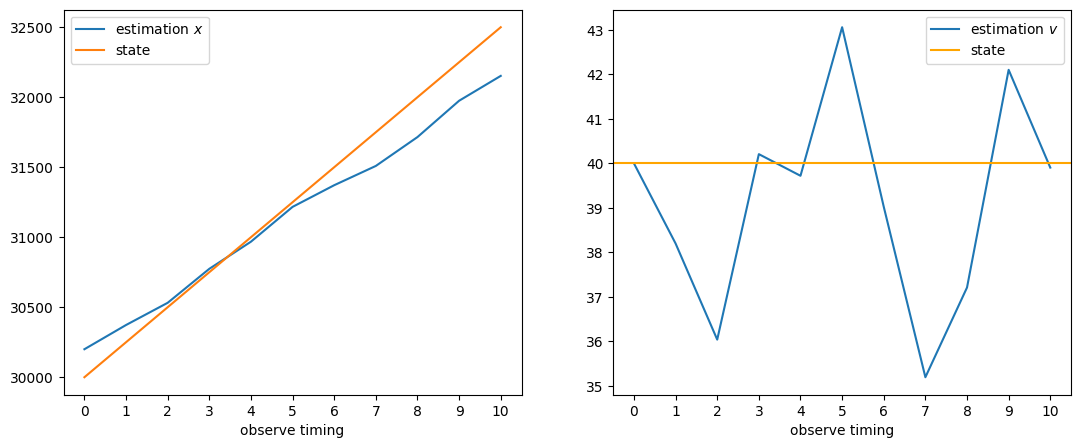

In [62]:
alpha = 0.2
beta = 0.1
x = 30000
v = 40
Dt = 5
T = 50
v_est = [40]
x = x + v * Dt
x_est = [x]
z_n = [30110, 30265, 30740, 30750, 31135, 31015,31180,31610,31960, 31865]
n = len(z_n)
for z in z_n:
    e = z - x #イノベーションを計算
    x = x + alpha * e #xの推定値を計算
    v = v + beta * (e/Dt) #vの推定値を計算
    x = x + v * Dt #xの予測値を計算
    v_est.append(v)
    x_est.append(x)
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(np.arange(0, n+1), np.array(x_est), label="estimation $x$")
ax1.plot(np.arange(0, n+1), x_n[:11], label="state")
ax1.set_xlabel("observe timing")
ax1.set_xticks(np.arange(0, n+1))

ax2.plot(np.arange(0, n+1), v_est, label="estimation $v$")
ax2.axhline(40, xmin=0, xmax=20, label="state", color="orange")
ax2.set_xlabel("observe timing")
ax2.set_xticks(np.arange(0, n+1))

ax1.legend()
ax2.legend()
plt.show()